In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


# Dataset

In [2]:
training_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
img, label = training_data[0]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 9


## Iterating and Visualizing the Dataset

We can index ``Datasets`` manually like a list: ``training_data[index]``.
We use ``matplotlib`` to visualize some samples in our training data.



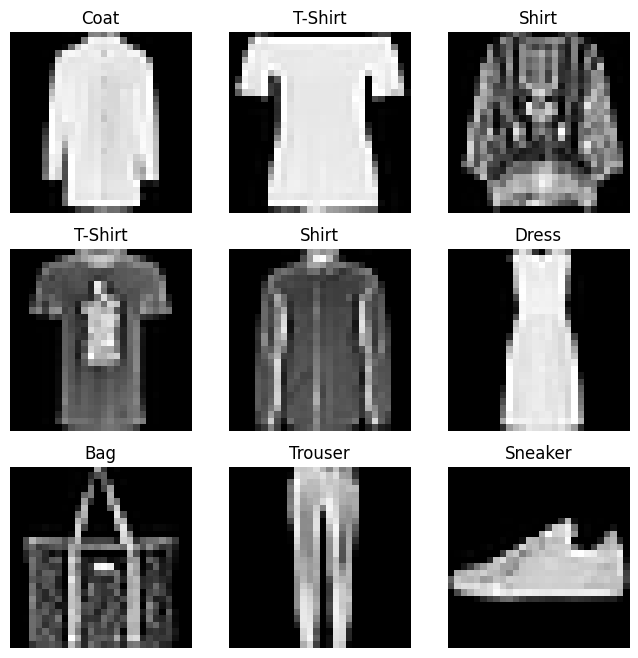

In [4]:
# dictionary of class names
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    # get a random sample from the training data
    sample_idx = torch.randint(len(training_data), size=(1,)).item()

    # get the image and label from the training data
    img, label = training_data[sample_idx]
    
    # plot the image
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

# Dataloader

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader

We have loaded that dataset into the ``DataLoader`` and can iterate through the dataset as needed.
Each iteration below returns a batch of ``train_features`` and ``train_labels`` (containing ``batch_size=64`` features and labels respectively).
Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled (for finer-grained control over
the data loading order, take a look at [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).



In [6]:
# Display image and label of a batch
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


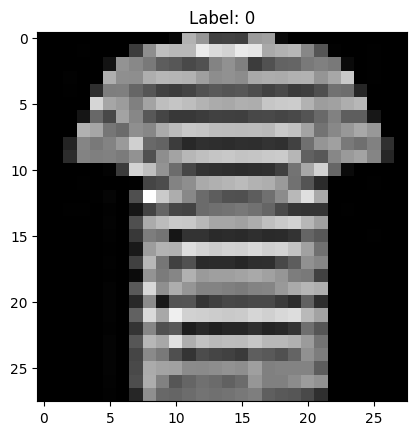

In [7]:
img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

# Build the Neural Network

Neural networks comprise of layers/modules that perform operations on data.
The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace provides all the building blocks you need to
build your own neural network. Every module in PyTorch subclasses the [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules (layers). This nested structure allows for
building and managing complex architectures easily.

In the following sections, we'll build a neural network to classify images in the FashionMNIST dataset.


In [8]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Get Device for Training
We want to be able to train our model on a hardware accelerator like the GPU or MPS,
if available. Let's check to see if [torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html)
or [torch.backends.mps](https://pytorch.org/docs/stable/notes/mps.html) are available, otherwise we use the CPU.



In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Define the Class
We define our neural network by subclassing ``nn.Module``, and
initialize the neural network layers in ``__init__``. Every ``nn.Module`` subclass implements
the operations on input data in the ``forward`` method.



In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of ``NeuralNetwork``, and move it to the ``device``, and print
its structure.



In [11]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model's ``forward``,
along with some [background operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call ``model.forward()`` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output.
We get the prediction probabilities by passing it through an instance of the ``nn.Softmax`` module.



In [12]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0], device='mps:0')


# Optimizing Model Parameters

Now that we have a model and data it's time to train, validate and test our model by optimizing its parameters on
our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates
the error in its guess (*loss*), collects the derivatives of the error with respect to its parameters (as we saw in
the Autorgrad section above, and **optimizes** these parameters using gradient descent. For a more
detailed walkthrough of this process, check out this video on [backpropagation from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

## Prerequisite Code
We load the code from the previous sections in one step.


In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

## Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process.
Different hyperparameter values can impact model training and convergence rates
([read more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)_ about hyperparameter tuning)

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.




In [14]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [15]:

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


## Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each
iteration of the optimization loop is called an **epoch**.

Each epoch consists of two main parts:
 - **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
 - **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to
see the `full-impl-label` of the optimization loop.

### Loss Function

When presented with some training data, our untrained network is likely not to give the correct
answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value,
and it is the loss function that we want to minimize during training. To calculate the loss we make a
prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output logits to ``nn.CrossEntropyLoss``, which will normalize the logits and compute the prediction error.



In [16]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).
All optimization logic is encapsulated in  the ``optimizer`` object. Here, we use the SGD optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html)
available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.



In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
 * Call ``optimizer.zero_grad()`` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to ``loss.backward()``. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.




## Full Implementation
We define ``train_loop`` that loops over our optimization code, and ``test_loop`` that
evaluates the model's performance against our test data.



In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    loss_sum = 0.0
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        loss_sum += loss.detach()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    return loss_sum / len(dataloader)


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, accuracy

We initialize the loss function and optimizer, and pass it to ``train_loop`` and ``test_loop``.
Feel free to increase the number of epochs to track the model's improving performance.



In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
train_losses = []
test_losses = []
test_accuracies = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, accuracy = test_loop(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

print("Done!")

Epoch 1
-------------------------------
loss: 0.527888  [   64/60000]
loss: 0.626604  [ 6464/60000]
loss: 0.412395  [12864/60000]
loss: 0.679781  [19264/60000]
loss: 0.606254  [25664/60000]
loss: 0.574351  [32064/60000]
loss: 0.610960  [38464/60000]
loss: 0.661409  [44864/60000]
loss: 0.680450  [51264/60000]
loss: 0.595177  [57664/60000]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.591412 

Epoch 2
-------------------------------
loss: 0.517145  [   64/60000]
loss: 0.615733  [ 6464/60000]
loss: 0.404125  [12864/60000]
loss: 0.671191  [19264/60000]
loss: 0.599596  [25664/60000]
loss: 0.568545  [32064/60000]
loss: 0.601099  [38464/60000]
loss: 0.658503  [44864/60000]
loss: 0.676513  [51264/60000]
loss: 0.585472  [57664/60000]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.583605 

Epoch 3
-------------------------------
loss: 0.507106  [   64/60000]
loss: 0.605601  [ 6464/60000]
loss: 0.396476  [12864/60000]
loss: 0.662966  [19264/60000]
loss: 0.593188  [25664/60000]
loss: 0.563036  [32064/600

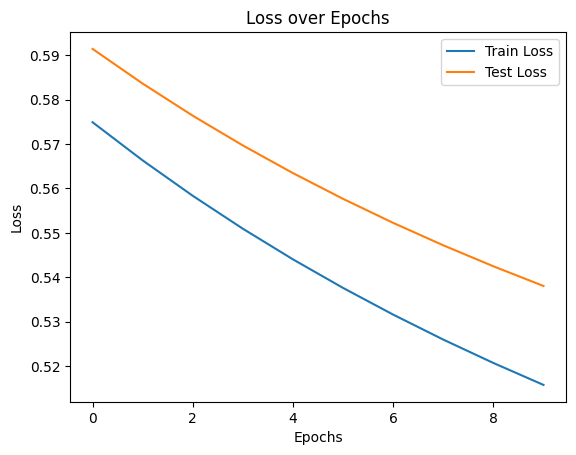

In [42]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


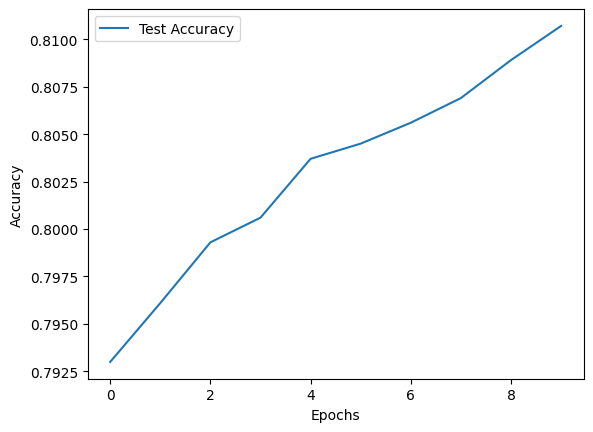

In [45]:
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
